# **Fake News Detection**

Our time is a time of abundant information, accompanied by a lot of digital misinformation. So, automated methods of verifying the integrity of Internet news usually combine information retrieval, natural language processing (NLP), and machine learning (ML) techniques. (WELFake) is a dataset of 72,134 news articles with 35,028 real and 37,106 fake news.

The Dataset: https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification

##**Libraries**

In [ ]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import nltk
import xgboost as xgb
import lightgbm as lgb
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from nltk import ngrams, FreqDist, RegexpTokenizer
import os

nltk.download('stopwords')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Reading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_path = '/content/drive/MyDrive'
csv_path = os.path.join(drive_path, '/content/drive/MyDrive/Fake News/WELFake_Dataset.csv')
news_data = pd.read_csv(csv_path)
ColumnName='text'


In [ ]:
news_data.shape

(72134, 4)

# **Data PreProcessing**

**Remove Null Values**

In [ ]:
news_data.isnull().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

Replacing the null values with empty string


In [ ]:
news_data = news_data.fillna('')

Checking the number of missing values in the dataset


In [ ]:
news_data.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

**Delete duplicates**

In [ ]:
item0 = news_data.shape[0]
news_data = news_data.drop_duplicates()
item1 = news_data.shape[0]
print(f"There are {item0-item1} duplicates found in the dataset")

There are 0 duplicates found in the dataset


Separating the data & label


In [ ]:
#Get the Independent Features
X = news_data.drop(columns=[ 'label', 'title'], axis=1)
X.drop(['Unnamed: 0'], axis=1, inplace=True)
Y = news_data['label']

In [ ]:
print(X.columns)

Index(['text'], dtype='object')


**Distribution of Fake - 0 & Real - 1 News**

In [ ]:
Y.value_counts()


1    37106
0    35028
Name: label, dtype: int64

Text(0.5, 1.0, 'Distribution of Fake - 1 & Real - 0 News')

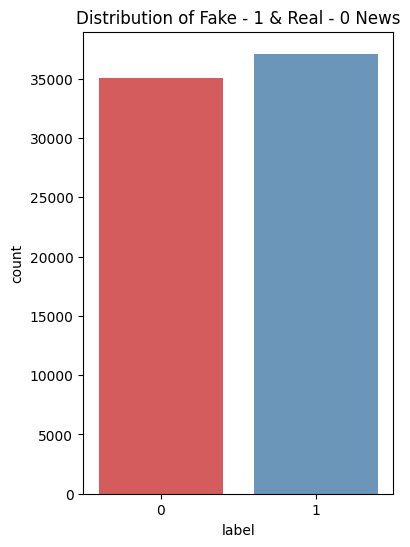

In [ ]:
plt.figure(figsize = (4,6))
sns.countplot(x = news_data['label'], palette = 'Set1', alpha = 0.8)
plt.title('Distribution of Fake - 1 & Real - 0 News')

**Top 10 Most Common Bigrams in Fake & Real News**

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Most common bigrams in fake news: [(('donald', 'trump'), 20850), (('hillari', 'clinton'), 16646), (('unit', 'state'), 12116), (('white', 'hous'), 9652), (('featur', 'imag'), 8399), (('twitter', 'com'), 7465), (('new', 'york'), 7136), (('pic', 'twitter'), 6968), (('imag', 'via'), 6550), (('presid', 'obama'), 5210)]
Most common bigrams in real news: [(('unit', 'state'), 22287), (('mr', 'trump'), 17629), (('donald', 'trump'), 15208), (('white', 'hous'), 14013), (('new', 'york'), 12839), (('presid', 'donald'), 7137), (('last', 'year'), 7118), (('washington', 'reuter'), 6674), (('north', 'korea'), 6666), (('islam', 'state'), 6292)]


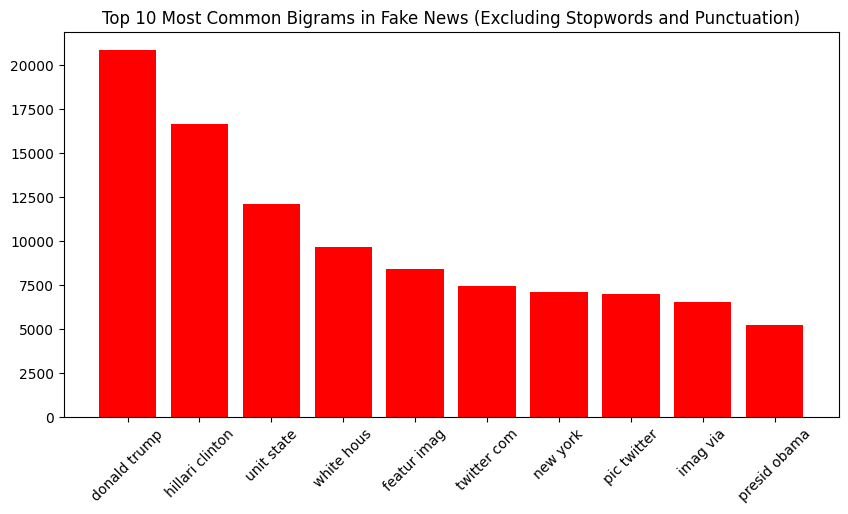

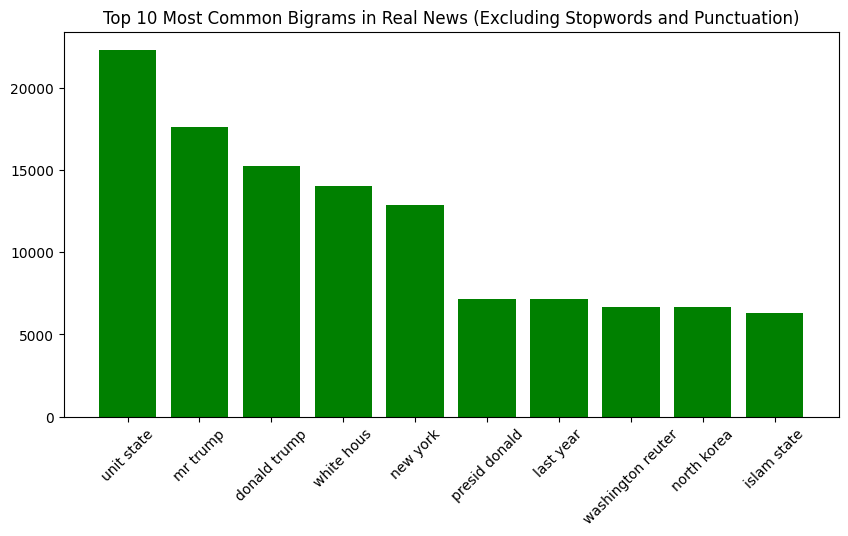

In [ ]:
stop_words = set(stopwords.words('english'))

# Regular expression tokenizer to capture only word characters
tokenizer = RegexpTokenizer(r'\w+')


# Separate the dataset into fake and real news
fake_news = news_data[news_data['label'] == 1]
real_news = news_data[news_data['label'] == 0]

# Function to find most common n-grams excluding stopwords and punctuation
def get_most_common_ngrams(text, n=2, num_ngrams=10):
    ngrams_list = []
    for item in text:
        tokens = [word for word in tokenizer.tokenize(item) if word.lower() not in stop_words]
        ngrams_list.extend(list(ngrams(tokens, n)))
    ngram_freq = FreqDist(ngrams_list)
    most_common_ngrams = ngram_freq.most_common(num_ngrams)
    return most_common_ngrams

# Most common bigrams in fake news
fake_common_bigrams = get_most_common_ngrams(fake_news['text'])
print("Most common bigrams in fake news:", fake_common_bigrams)

# Most common bigrams in real news
real_common_bigrams = get_most_common_ngrams(real_news['text'])
print("Most common bigrams in real news:", real_common_bigrams)

# Visualization function for n-grams
def plot_most_common_ngrams(ngrams, title, color):
    ngrams, freqs = zip(*ngrams)
    ngrams = [' '.join(gram) for gram in ngrams]
    plt.figure(figsize=(10, 5))
    plt.bar(ngrams, freqs, color=color)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Plotting the most common bigrams
plot_most_common_ngrams(fake_common_bigrams, 'Top 10 Most Common Bigrams in Fake News (Excluding Stopwords and Punctuation)', 'red')
plot_most_common_ngrams(real_common_bigrams, 'Top 10 Most Common Bigrams in Real News (Excluding Stopwords and Punctuation)', 'green')

In [ ]:
X.shape

(72134, 1)

In [ ]:
Y.shape

(72134,)

In [ ]:
print(X)
print(Y)

                                                    text
0      No comment is expected from Barack Obama Membe...
1         Did they post their votes for Hillary already?
2       Now, most of the demonstrators gathered last ...
3      A dozen politically active pastors came here f...
4      The RS-28 Sarmat missile, dubbed Satan 2, will...
...                                                  ...
72129  WASHINGTON (Reuters) - Hackers believed to be ...
72130  You know, because in fantasyland Republicans n...
72131  Migrants Refuse To Leave Train At Refugee Camp...
72132  MEXICO CITY (Reuters) - Donald Trump’s combati...
72133  Goldman Sachs Endorses Hillary Clinton For Pre...

[72134 rows x 1 columns]
0        1
1        1
2        1
3        0
4        1
        ..
72129    0
72130    1
72131    0
72132    0
72133    1
Name: label, Length: 72134, dtype: int64



**Stemming**

A stemming algorithm is a linguistic normalization process in which a word's variant forms are reduced to a standard format. In simple terms, Stemming is lowering a comment to its Root word.

In [ ]:
port_stem = PorterStemmer()

In [ ]:
def stemming(content):
    review = re.sub('[^a-zA-Z]',' ',content)
    review = review.lower()
    review = review.split()
    review = [port_stem.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    return review

In [ ]:
news_data['text'] = news_data['text'].apply(stemming)


In [ ]:
print(news_data['text'])

0        comment expect barack obama member fyf fukyofl...
1                                post vote hillari alreadi
2        demonstr gather last night exercis constitut p...
3        dozen polit activ pastor came privat dinner fr...
4        rs sarmat missil dub satan replac ss fli mile ...
                               ...                        
72129    washington reuter hacker believ work russian g...
72130    know fantasyland republican never question cit...
72131    migrant refus leav train refuge camp hungari t...
72132    mexico citi reuter donald trump comb style buf...
72133    goldman sach endors hillari clinton presid gol...
Name: text, Length: 72134, dtype: object


Separating the data and label


In [ ]:
X = news_data['text'].values
Y = news_data['label'].values

In [ ]:
print(X)

['comment expect barack obama member fyf fukyoflag blacklivesmatt movement call lynch hang white peopl cop encourag other radio show tuesday night turn tide kill white peopl cop send messag kill black peopl america one f yoflag organ call sunshin radio blog show host texa call sunshin f ing opinion radio show snapshot fyf lolatwhitefear twitter page p show urg support call fyf tonight continu dismantl illus white snapshot twitter radio call invit fyf radio show air p eastern standard time show caller clearli call lynch kill white peopl minut clip radio show heard provid breitbart texa someon would like refer hannib alreadi receiv death threat result interrupt fyf confer call unidentifi black man said mother f ker start f ing like us bunch ni er takin one us roll said caus alreadi roll gang anyway six seven black mother f cker see white person lynch ass let turn tabl conspir cop start lose peopl state emerg specul one two thing would happen big ass r war ni er go start backin alreadi ge

In [ ]:
print(Y)

[1 1 1 ... 0 0 1]


In [ ]:
Y.shape

(72134,)

**TF-IDF (Term Frequency – Inverse Document Frequency )**

TF-IDF is a numerical statistic that measures the importance of the word in a document.

* Term Frequency: Number of times a word appears in a text document.

* Inverse Document Frequency: Measure the word is a rare or common word in a document.





converting the textual data to numerical data


In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X = vectorizer.transform(X)

In [ ]:
print(X)

  (0, 159295)	0.0262988085030883
  (0, 159225)	0.021471185726041522
  (0, 159021)	0.1389328344130979
  (0, 158601)	0.045029570199072354
  (0, 156517)	0.019870771205942675
  (0, 155503)	0.03469695024659386
  (0, 155069)	0.023450266181365396
  (0, 154723)	0.13196421795654398
  (0, 154540)	0.025343235501281
  (0, 154051)	0.014307866541578038
  (0, 153761)	0.023050399210410983
  (0, 153471)	0.013626625567407574
  (0, 153327)	0.06701572139357796
  (0, 153048)	0.03484194217668632
  (0, 152865)	0.05689794071472405
  (0, 150875)	0.018086474050324784
  (0, 150606)	0.05201876063916658
  (0, 148788)	0.032886624545194976
  (0, 148506)	0.04319292587344014
  (0, 148419)	0.022763957183831923
  (0, 148299)	0.029409476283091283
  (0, 148276)	0.0332229039365008
  (0, 147352)	0.03335975867900833
  (0, 147334)	0.037090355018592154
  (0, 146646)	0.04213600551066033
  :	:
  (72133, 29684)	0.037201034352271206
  (72133, 29241)	0.028433031546252218
  (72133, 29183)	0.01894381815969959
  (72133, 29086)	0.03452

**Model Training**





**Splitting the Dataset into Training and Testing**


In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=2)

**Confusion Matrix Function**
The confusion matrix is a 2 dimensional array comparing predicted category labels to the true label.

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Purples):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**First Classifier : Random Forest Classifier**
Is an ensemble learning method that belongs to the bagging family of algorithms. It is used for both classification and regression tasks.

Accuracy:   0.868
Confusion matrix, without normalization


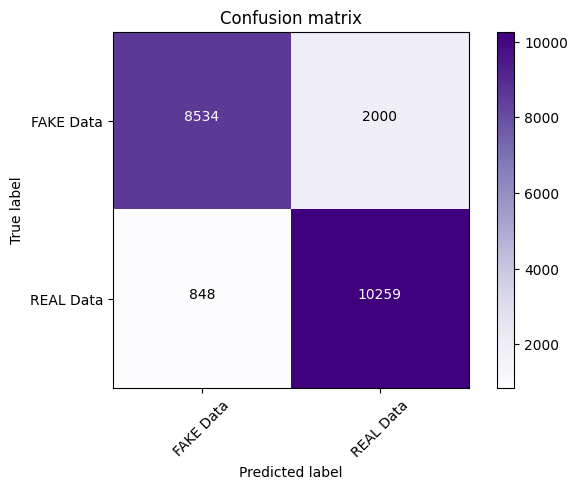

In [ ]:
RF_Model = RandomForestClassifier(n_estimators=150, max_depth=12, random_state=42)

RF_Model.fit(X_train, y_train)
y_pred = RF_Model.predict(X_test)
RF_acc = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:   %0.3f" % RF_acc)

cm2 = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm2, classes=['FAKE Data', 'REAL Data'])

**Classifcation Report:**

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.81      0.86     10534
           1       0.84      0.92      0.88     11107

    accuracy                           0.87     21641
   macro avg       0.87      0.87      0.87     21641
weighted avg       0.87      0.87      0.87     21641



**Test the model**

In [ ]:
X_new = X_test[0]

prediction = RF_Model.predict(X_new)
print(prediction)

if (prediction[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')




[0]
The news is Real


In [ ]:
print(y_test[0])


0


**Second Classifier: SVM**

A powerful and versatile machine learning algorithm used for both classification and regression tasks. SVM operates by finding a hyperplane that best separates data points of different classes in a high-dimensional space.

accuracy:   0.956
Confusion matrix, without normalization


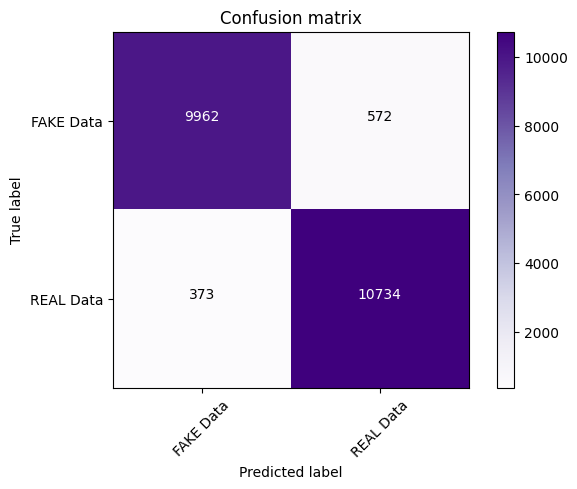

In [ ]:
svm_model = SVC(kernel ='linear', C = 1.0, coef0 = 0.5, degree = 1 , gamma = "scale" )

# Train the SVM model
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)

Svm_acc = metrics.accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % Svm_acc)
cm2 = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm2, classes=['FAKE Data', 'REAL Data'])

**Classifcation Report**

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95     10534
           1       0.95      0.97      0.96     11107

    accuracy                           0.96     21641
   macro avg       0.96      0.96      0.96     21641
weighted avg       0.96      0.96      0.96     21641



**Test the model**

In [ ]:
X_new = X_test[0]

prediction = svm_model.predict(X_new)
print(prediction)

if (prediction[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')



[0]
The news is Real


In [ ]:
print(y_test[0])

0


**Third Classifier:  AdaBoost Classifier**

Short for Adaptive Boosting, is an ensemble learning method that is used for classification and regression tasks. It works by combining the predictions of multiple weak learners (models that perform slightly better than random chance) to create a strong classifier.

accuracy:   0.935
Confusion matrix, without normalization


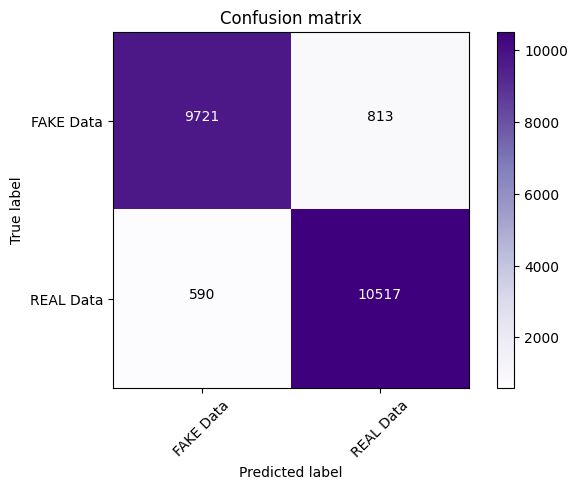

In [ ]:
AdaB_model = AdaBoostClassifier(n_estimators=150)
# Train the decision tree model
AdaB_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = AdaB_model.predict(X_test)

AdaB_acc = metrics.accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % AdaB_acc)
cm2 = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm2, classes=['FAKE Data', 'REAL Data'])

**Classifcation Report**

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     10534
           1       0.93      0.95      0.94     11107

    accuracy                           0.94     21641
   macro avg       0.94      0.93      0.94     21641
weighted avg       0.94      0.94      0.94     21641



**Test the model**

In [ ]:
X_new = X_test[0]

prediction = AdaB_model.predict(X_new)
print(prediction)

if (prediction[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

[0]
The news is Real


In [ ]:
print(y_test[0])

0


**Fourth Classifier: Xgboost**

Short for extreme Gradient Boosting, is a popular and powerful machine learning algorithm designed for classification and regression tasks. It belongs to the family of gradient boosting algorithms and has gained widespread adoption due to its efficiency, scalability, and high predictive performance

accuracy:   0.964
Confusion matrix, without normalization


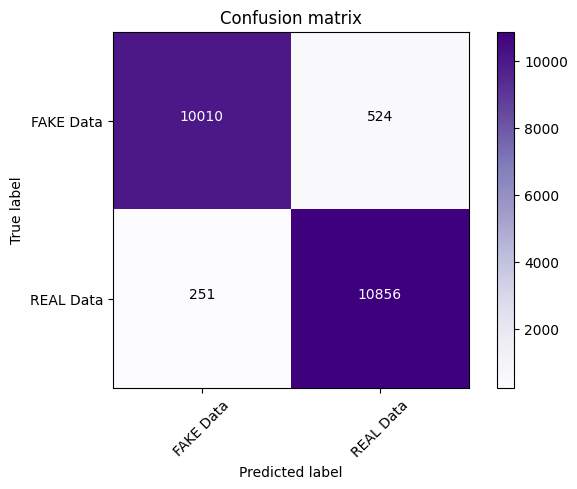

In [ ]:
Xg_model = xgb.XGBClassifier(n_estimators=200)
Xg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = Xg_model.predict(X_test)

Xg_acc = metrics.accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % Xg_acc)
cm2 = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm2, classes=['FAKE Data', 'REAL Data'])

**Classifcation Report**

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96     10534
           1       0.95      0.98      0.97     11107

    accuracy                           0.96     21641
   macro avg       0.96      0.96      0.96     21641
weighted avg       0.96      0.96      0.96     21641



**Test the model**

In [ ]:
X_new = X_test[0]

prediction = Xg_model.predict(X_new)
print(prediction)

if (prediction[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

[0]
The news is Real


In [ ]:
print(y_test[0])

0


**Fifth Classifier: Bagging Classifier**

Short for Bootstrap Aggregating Classifier, is an ensemble learning method designed to improve the stability and accuracy of machine learning models. It works by training multiple instances of the same base classifier on different subsets of the training data, and then combining their predictions.

accuracy:   0.938
Confusion matrix, without normalization


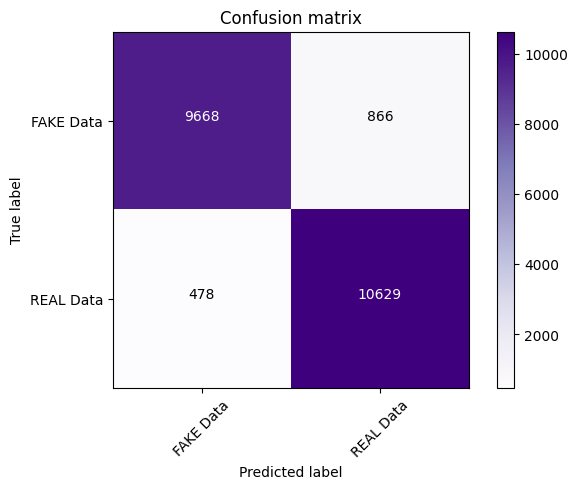

In [ ]:
base_classifier = DecisionTreeClassifier(
    criterion='gini',
    splitter='best'
)
Bag_model = BaggingClassifier(base_classifier)
Bag_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = Bag_model.predict(X_test)

Bag_acc = metrics.accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % Bag_acc)
cm2 = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm2, classes=['FAKE Data', 'REAL Data'])

**Classifcation Report**

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94     10534
           1       0.92      0.96      0.94     11107

    accuracy                           0.94     21641
   macro avg       0.94      0.94      0.94     21641
weighted avg       0.94      0.94      0.94     21641



**Tast the model**

In [ ]:
X_new = X_test[0]

prediction = Bag_model.predict(X_new)
print(prediction)

if (prediction[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

[0]
The news is Real


In [ ]:
print(y_test[0])

0


**Sixth Classifier: LGBM**

LightGBM (Light Gradient Boosting Machine) is a gradient boosting framework that is specifically designed for speed and efficiency. It belongs to the family of boosting algorithms and is known for its high performance in terms of both training speed and predictive accuracy.

[LightGBM] [Info] Number of positive: 25999, number of negative: 24494
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.860921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1227031
[LightGBM] [Info] Number of data points in the train set: 50493, number of used features: 16952
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.514903 -> initscore=0.059630
[LightGBM] [Info] Start training from score 0.059630
accuracy:   0.966
Confusion matrix, without normalization


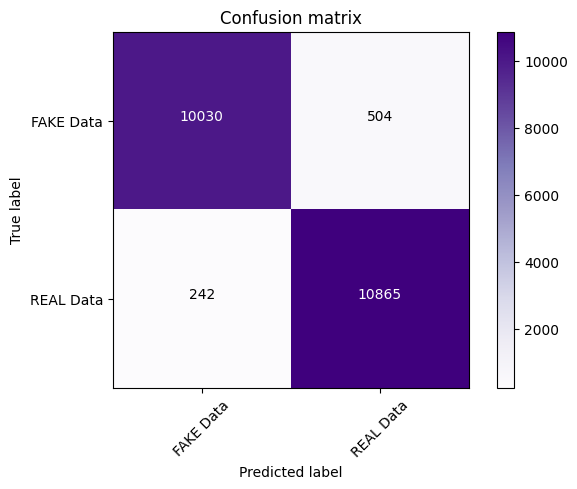

In [ ]:
LGBM_model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-12,
    learning_rate=0.1,
    n_estimators=200,

)
LGBM_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = LGBM_model.predict(X_test)

LGBM_acc = metrics.accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % LGBM_acc)
cm2 = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm2, classes=['FAKE Data', 'REAL Data'])

**Classifcation Report**

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96     10534
           1       0.96      0.98      0.97     11107

    accuracy                           0.97     21641
   macro avg       0.97      0.97      0.97     21641
weighted avg       0.97      0.97      0.97     21641



**Test the model**

In [ ]:
X_new = X_test[0]

prediction = LGBM_model.predict(X_new)
print(prediction)

if (prediction[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

[0]
The news is Real


In [ ]:
print(y_test[0])

0


**Seventh Classifier: Gradient Boosting**

 is a machine learning technique used for both regression and classification tasks. It is an ensemble learning method that combines the predictions of several weak learners (typically decision trees) to create a strong learner.

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/di

accuracy:   0.925
Confusion matrix, without normalization


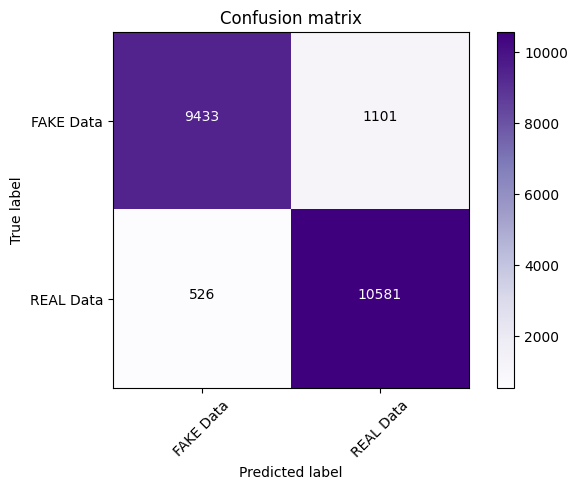

In [ ]:
GB_model= GradientBoostingClassifier(

    learning_rate= 0.1,
    max_depth= 3,
    max_features= 'auto',
    min_samples_leaf= 2,
    min_samples_split= 5,
    n_estimators= 100
                                )


GB_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = GB_model.predict(X_test)

GB_acc = metrics.accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % GB_acc)
cm2 = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm2, classes=['FAKE Data', 'REAL Data'])

**Classifcation Report**

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92     10534
           1       0.91      0.95      0.93     11107

    accuracy                           0.92     21641
   macro avg       0.93      0.92      0.92     21641
weighted avg       0.93      0.92      0.92     21641



**Test the model**

In [ ]:
X_new = X_test[0]

prediction = LGBM_model.predict(X_new)
print(prediction)

if (prediction[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

[0]
The news is Real


In [ ]:
print(y_test[0])

0


## **Accuracy for all classifiers**

Text(0, 0.5, 'Accuracy')

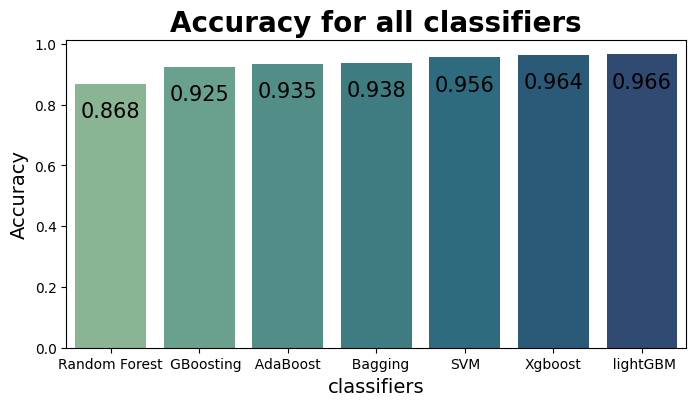

In [ ]:
all_accuracy = [RF_acc,Svm_acc,AdaB_acc,Xg_acc,Bag_acc,LGBM_acc,GB_acc]
algo = ['Random Forest', 'SVM', '  AdaBoost  ','Xgboost','  Bagging','  lightGBM ' ,'   GBoosting']

# define dictionary
inter_dict ={'classifiers':algo,
            'Accuracy':all_accuracy}

#create DataFrame from dictionary
df_acc = pd.DataFrame(inter_dict)

# Sort DataFrame by 'Accuracy' column in ascending order
df_acc = df_acc.sort_values(by='Accuracy')

fig = plt.figure(figsize=(8,4))
ax=sns.barplot(data=df_acc, x='classifiers', y = 'Accuracy',palette="crest")
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, -20),
                   textcoords = 'offset points', size=15)

plt.title("Accuracy for all classifiers", size=20, weight='bold')
plt.xlabel("classifiers", size=14)
plt.ylabel("Accuracy", size=14)


**Description of the Chart**

As shown above, the bar chart visualizes the accuracy of various machine-learning classifiers. Xgboost, lightGBM, and SVM exhibit the highest accuracies, with lightGBM leading at 96.6%.


**Conclusion**

This study investigated the performance of seven machine learning algorithms for classifying fake news articles. The results demonstrated that the lightGBM algorithm outperformed the other algorithms, achieving an accuracy of 96.6%, precision of 97%, and recall of 97%. These findings suggest that the lightGBM algorithm is a promising tool for improving the accuracy of news classification, which could have implications for data security and other applications.

**Grid Search**

**SVM Classifier**

Utilizing Grid Search on a subset of 3,000 articles, we effectively optimized the SVM algorithm, resulting in a substantial accuracy improvement from 90.4% to 95.6% on the 70,000-article dataset.


```
svm= SVC()
para_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'] + [0.1, 1, 10],
    'degree': [1,2, 3, 4],
    'coef0': [ 0.5, 1.0]
}


grid_svm = GridSearchCV(svm, param_grid=para_svm, cv=10,  verbose=3) #search svm
grid_svm.fit(X_train, y_train)

```
The best hyperparameter was :



```
SVC ( kernel='linear', C=1.0, coef0= 0.5, degree = 1 , gamma = 'scale' )

```




### **Gradient Boosting Classifier**

Utilizing Grid Search on a subset of 3,000 articles, we effectively optimized the Gradient Boosting algorithm, resulting in a substantial accuracy improvement from 91.3% to 92.5% on the 70,000-article dataset.



```
gb= GradientBoostingClassifier()

para_gb = {
 'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 1],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
   'max_features': ['auto', 'sqrt', 'log2']
}
grid_gb = GridSearchCV(estimator=gb, param_grid=para_gb, cv=10, verbose=3)

```
The best hyperparameter was :



```
GB_model= GradientBoostingClassifier(

    learning_rate= 0.1,
    max_depth= 3,
    max_features= 'auto',
    min_samples_leaf= 2,
    min_samples_split= 5,
    n_estimators= 100
                                )


```
